In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! echo $PYTHONPATH

/env/python


In [3]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings

warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [6]:
ts = data['2018-03-30':'2018-09-29']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


In [20]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,5430.000000,5430.000000,5430.0,5430.000000,5430.00000
mean,290.070619,0.178206,0.0,44.658011,3296.05267
std,9.153027,0.748593,0.0,38.832373,1985.41250
min,259.650000,0.000000,0.0,0.000000,151.00000
25%,287.020000,0.000000,0.0,1.000000,1249.25000
50%,292.080000,0.000000,0.0,40.000000,3446.00000
75%,295.925000,0.000000,0.0,90.000000,4942.75000
max,310.070000,10.600000,0.0,92.000000,7213.00000


In [21]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [25]:
x_train = np.array(ts_train['traffic_volume'])
x_valid = np.array(ts_test['traffic_volume'])

time_train = np.array(ts_train['date_time'])
time_valid = np.array(ts_test['date_time'])


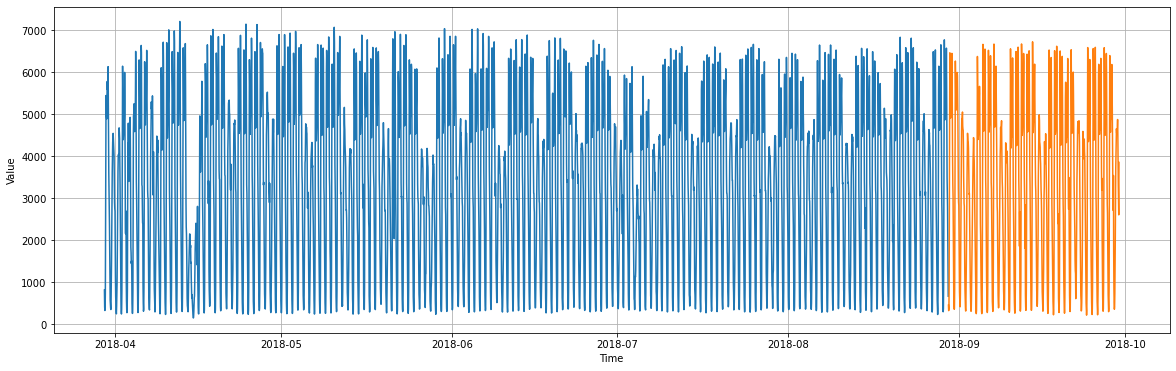

In [28]:
plt.figure(figsize=(20, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)


In [29]:
print(len(time_train))
print(len(x_train))
print(len(time_valid))
print(len(x_valid))

4462
4462
968
968


In [30]:
window_size = 24
batch_size = 32
shuffle_buffer_size = 1000

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [32]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 24
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))>
(4462,)


# LSTM

Epoch 1/300
18/18 [==============================] - 14s 41ms/step - loss: 2658.5620 - mae: 2659.0620 - lr: 1.0000e-08
Epoch 2/300
18/18 [==============================] - 1s 37ms/step - loss: 2180.5457 - mae: 2181.0459 - lr: 1.1220e-08
Epoch 3/300
18/18 [==============================] - 1s 36ms/step - loss: 1833.1180 - mae: 1833.6180 - lr: 1.2589e-08
Epoch 4/300
18/18 [==============================] - 1s 37ms/step - loss: 1615.3643 - mae: 1615.8640 - lr: 1.4125e-08
Epoch 5/300
18/18 [==============================] - 1s 38ms/step - loss: 1467.3978 - mae: 1467.8976 - lr: 1.5849e-08
Epoch 6/300
18/18 [==============================] - 1s 42ms/step - loss: 1325.5571 - mae: 1326.0571 - lr: 1.7783e-08
Epoch 7/300
18/18 [==============================] - 1s 41ms/step - loss: 1216.3636 - mae: 1216.8636 - lr: 1.9953e-08
Epoch 8/300
18/18 [==============================] - 1s 36ms/step - loss: 1132.9027 - mae: 1133.4025 - lr: 2.2387e-08
Epoch 9/300
18/18 [==============================] - 1s

18/18 [==============================] - 1s 36ms/step - loss: 1112.7440 - mae: 1113.2439 - lr: 2.8184e-05
Epoch 71/300
18/18 [==============================] - 1s 35ms/step - loss: 1194.3147 - mae: 1194.8147 - lr: 3.1623e-05
Epoch 72/300
18/18 [==============================] - 1s 34ms/step - loss: 1207.6027 - mae: 1208.1028 - lr: 3.5481e-05
Epoch 73/300
18/18 [==============================] - 1s 35ms/step - loss: 1259.8820 - mae: 1260.3817 - lr: 3.9811e-05
Epoch 74/300
18/18 [==============================] - 1s 36ms/step - loss: 1179.8634 - mae: 1180.3635 - lr: 4.4668e-05
Epoch 75/300
18/18 [==============================] - 1s 36ms/step - loss: 1406.1790 - mae: 1406.6787 - lr: 5.0119e-05
Epoch 76/300
18/18 [==============================] - 1s 35ms/step - loss: 1309.0488 - mae: 1309.5487 - lr: 5.6234e-05
Epoch 77/300
18/18 [==============================] - 1s 34ms/step - loss: 1381.2668 - mae: 1381.7670 - lr: 6.3096e-05
Epoch 78/300
18/18 [==============================] - 1s 34ms

18/18 [==============================] - 1s 36ms/step - loss: 2370879.0000 - mae: 2370879.5000 - lr: 0.0708
Epoch 139/300
18/18 [==============================] - 1s 36ms/step - loss: 2660666.5000 - mae: 2660667.0000 - lr: 0.0794
Epoch 140/300
18/18 [==============================] - 1s 36ms/step - loss: 2984796.5000 - mae: 2984797.0000 - lr: 0.0891
Epoch 141/300
18/18 [==============================] - 1s 36ms/step - loss: 3349509.2500 - mae: 3349510.0000 - lr: 0.1000
Epoch 142/300
18/18 [==============================] - 1s 36ms/step - loss: 3757723.0000 - mae: 3757723.2500 - lr: 0.1122
Epoch 143/300
18/18 [==============================] - 1s 38ms/step - loss: 4216716.0000 - mae: 4216717.0000 - lr: 0.1259
Epoch 144/300
18/18 [==============================] - 1s 36ms/step - loss: 4730729.5000 - mae: 4730730.0000 - lr: 0.1413
Epoch 145/300
18/18 [==============================] - 1s 35ms/step - loss: 5308466.5000 - mae: 5308467.0000 - lr: 0.1585
Epoch 146/300
18/18 [=================

18/18 [==============================] - 1s 37ms/step - loss: 4216487168.0000 - mae: 4216486400.0000 - lr: 125.8925
Epoch 204/300
18/18 [==============================] - 1s 36ms/step - loss: 4730975232.0000 - mae: 4730975232.0000 - lr: 141.2538
Epoch 205/300
18/18 [==============================] - 1s 36ms/step - loss: 5308243456.0000 - mae: 5308242432.0000 - lr: 158.4893
Epoch 206/300
18/18 [==============================] - 1s 35ms/step - loss: 5955945472.0000 - mae: 5955944960.0000 - lr: 177.8279
Epoch 207/300
18/18 [==============================] - 1s 37ms/step - loss: 6682681344.0000 - mae: 6682681856.0000 - lr: 199.5262
Epoch 208/300
18/18 [==============================] - 1s 39ms/step - loss: 7498091008.0000 - mae: 7498092032.0000 - lr: 223.8721
Epoch 209/300
18/18 [==============================] - 1s 36ms/step - loss: 8412998656.0000 - mae: 8412998656.0000 - lr: 251.1886
Epoch 210/300
18/18 [==============================] - 1s 36ms/step - loss: 9439536128.0000 - mae: 94395

18/18 [==============================] - 1s 35ms/step - loss: 4730974633984.0000 - mae: 4730974633984.0000 - lr: 141253.7500
Epoch 265/300
18/18 [==============================] - 1s 36ms/step - loss: 5308243509248.0000 - mae: 5308243509248.0000 - lr: 158489.3125
Epoch 266/300
18/18 [==============================] - 1s 35ms/step - loss: 5955944710144.0000 - mae: 5955944710144.0000 - lr: 177827.9375
Epoch 267/300
18/18 [==============================] - 1s 36ms/step - loss: 6682683375616.0000 - mae: 6682682851328.0000 - lr: 199526.2344
Epoch 268/300
18/18 [==============================] - 1s 35ms/step - loss: 7498089103360.0000 - mae: 7498090151936.0000 - lr: 223872.1094
Epoch 269/300
18/18 [==============================] - 1s 35ms/step - loss: 8412997877760.0000 - mae: 8412998402048.0000 - lr: 251188.6406
Epoch 270/300
18/18 [==============================] - 1s 35ms/step - loss: 9439537004544.0000 - mae: 9439537004544.0000 - lr: 281838.2812
Epoch 271/300
18/18 [====================

(1e-08, 0.0001, 0.0, 60.0)

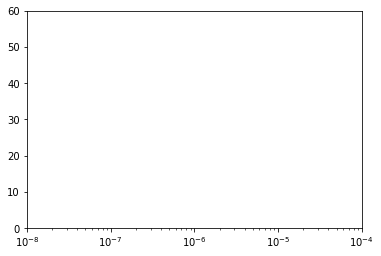

In [35]:
## tune learning rate

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 8000)

])
##
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
##
history = model.fit(train_set, epochs=300, callbacks=[lr_schedule])
##
plt.semilogx(history.history["lr"], history.history["loss"])

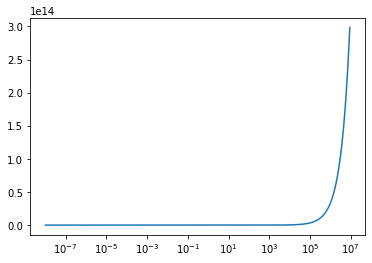

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])


In [81]:
tf.keras.backend.clear_session()

##
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=24, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
    tf.keras.layers.Lambda(lambda x: x * 8000)

])

In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [83]:
history = model.fit(train_set,validation_data=valid_set, epochs=300, callbacks=[es, rp]) 

Epoch 1/300
35/35 [==============================] - 22s 183ms/step - loss: 2379.8679 - mae: 2380.3660 - val_loss: 1101.6339 - val_mae: 1102.1315 - lr: 0.0010
Epoch 2/300
35/35 [==============================] - 4s 89ms/step - loss: 1404.8809 - mae: 1405.3784 - val_loss: 880.2041 - val_mae: 880.7013 - lr: 0.0010
Epoch 3/300
35/35 [==============================] - 4s 93ms/step - loss: 1217.8954 - mae: 1218.3929 - val_loss: 810.9940 - val_mae: 811.4918 - lr: 0.0010
Epoch 4/300
35/35 [==============================] - 4s 91ms/step - loss: 1094.9423 - mae: 1095.4402 - val_loss: 765.6470 - val_mae: 766.1448 - lr: 0.0010
Epoch 5/300
35/35 [==============================] - 4s 89ms/step - loss: 985.0988 - mae: 985.5967 - val_loss: 694.1146 - val_mae: 694.6123 - lr: 0.0010
Epoch 6/300
35/35 [==============================] - 4s 88ms/step - loss: 950.0217 - mae: 950.5195 - val_loss: 683.3958 - val_mae: 683.8936 - lr: 0.0010
Epoch 7/300
35/35 [==============================] - 4s 90ms/step - lo

35/35 [==============================] - 4s 107ms/step - loss: 453.1358 - mae: 453.6336 - val_loss: 420.7148 - val_mae: 421.2124 - lr: 0.0010
Epoch 55/300
35/35 [==============================] - 4s 108ms/step - loss: 452.5709 - mae: 453.0686 - val_loss: 413.6375 - val_mae: 414.1353 - lr: 0.0010
Epoch 56/300
35/35 [==============================] - 4s 101ms/step - loss: 442.7368 - mae: 443.2345 - val_loss: 413.6804 - val_mae: 414.1781 - lr: 0.0010
Epoch 57/300
35/35 [==============================] - 4s 99ms/step - loss: 442.7283 - mae: 443.2261 - val_loss: 402.3369 - val_mae: 402.8347 - lr: 0.0010
Epoch 58/300
35/35 [==============================] - 4s 109ms/step - loss: 436.8513 - mae: 437.3490 - val_loss: 401.2776 - val_mae: 401.7752 - lr: 0.0010
Epoch 59/300
35/35 [==============================] - 4s 107ms/step - loss: 423.0367 - mae: 423.5343 - val_loss: 384.0054 - val_mae: 384.5033 - lr: 2.0000e-04
Epoch 60/300
35/35 [==============================] - 4s 108ms/step - loss: 415.

Epoch 106/300
35/35 [==============================] - 4s 86ms/step - loss: 382.8214 - mae: 383.3192 - val_loss: 348.4911 - val_mae: 348.9886 - lr: 1.0000e-04
Epoch 107/300
35/35 [==============================] - 4s 87ms/step - loss: 383.9847 - mae: 384.4824 - val_loss: 346.0013 - val_mae: 346.4990 - lr: 1.0000e-04
Epoch 108/300
35/35 [==============================] - 4s 91ms/step - loss: 382.2756 - mae: 382.7732 - val_loss: 346.6302 - val_mae: 347.1279 - lr: 1.0000e-04
Epoch 109/300
35/35 [==============================] - 4s 88ms/step - loss: 380.6480 - mae: 381.1457 - val_loss: 345.0263 - val_mae: 345.5238 - lr: 1.0000e-04
Epoch 110/300
35/35 [==============================] - 4s 88ms/step - loss: 381.6166 - mae: 382.1143 - val_loss: 343.4352 - val_mae: 343.9329 - lr: 1.0000e-04
Epoch 111/300
35/35 [==============================] - 4s 92ms/step - loss: 380.5516 - mae: 381.0493 - val_loss: 342.2191 - val_mae: 342.7166 - lr: 1.0000e-04
Epoch 112/300
35/35 [=========================

In [84]:
### summarize history for loss
split_time = 4462
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

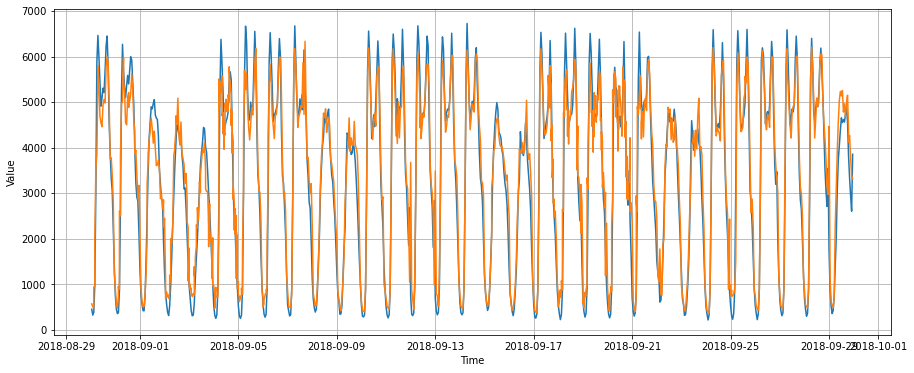

In [90]:
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

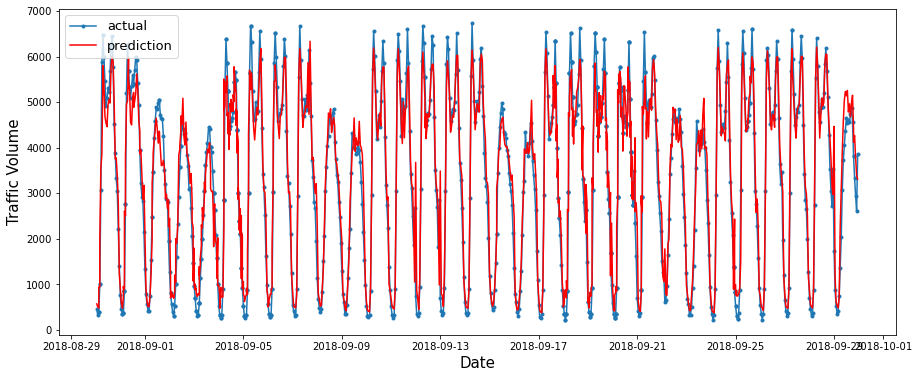

In [98]:
plt.figure(figsize=(15,6))
plt.plot(pd.DataFrame(time_valid)[0], pd.DataFrame(x_valid)[0], marker='.', label="actual")
plt.plot(pd.DataFrame(time_valid)[0], pd.DataFrame(rnn_forecast)[0], 'r', label="prediction")
#ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

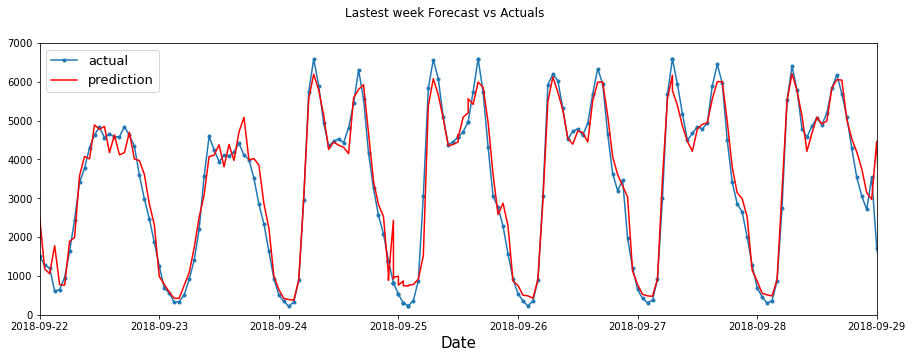

In [99]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(pd.DataFrame(time_valid)[0], pd.DataFrame(x_valid)[0], marker='.', label="actual")
plt.plot(pd.DataFrame(time_valid)[0], pd.DataFrame(rnn_forecast)[0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [100]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

417.60422

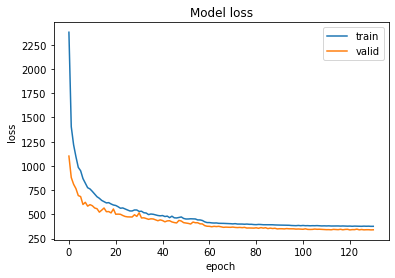

In [101]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()
